In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import datetime

matplotlib.style.use('ggplot')

In [2]:
# Directories
OUTPUT_DIR = '../Outputs/country_clusters/'
INPUT_DIR = '../Data/country_data/'
MACRO_DIR = '../Data/macro_factors/'

In [3]:
# Load ETF returns for Equities
equity_etfs = pd.read_csv(INPUT_DIR + 'ETF_adj_close.csv', index_col=0)
equity_etfs.index = pd.to_datetime(equity_etfs.index)

equity_etfs_w = equity_etfs.resample('W').last()
equity_rets_w = np.log(equity_etfs_w).diff()
equity_rets_w = equity_rets_w.dropna()

In [4]:
# Load market cap data for countries
country_mkt_cap = pd.read_csv(INPUT_DIR + 'country_market_caps.csv',skiprows=4)
country_mkt_cap = country_mkt_cap[country_mkt_cap.columns[~country_mkt_cap.columns.isin(['Country Code', 'Indicator Name', 'Indicator Code'])]]
country_mkt_cap = country_mkt_cap.T.rename_axis('Year')
country_mkt_cap = country_mkt_cap.rename(columns=country_mkt_cap.iloc[0]).drop(country_mkt_cap.index[0])

# Only select countries in EM universe
# Remove Taiwan since it doesn't exist in the market cap data; change names for Korea, Russia, Egypt for better search
em_countries = equity_rets_w.columns.values
em_countries = np.where(em_countries=='Korea', 'Korea, Rep.', em_countries) 
em_countries = np.where(em_countries=='Russia', 'Russian Federation', em_countries) 
em_countries = np.where(em_countries=='Egypt', 'Egypt, Arab Rep.', em_countries)
em_countries = em_countries[~np.isin(em_countries, 'Taiwan')]

start_year = 2015
country_mkt_cap = country_mkt_cap[em_countries]
country_mkt_cap.index = pd.to_numeric(country_mkt_cap.index)
country_mkt_cap = country_mkt_cap[country_mkt_cap.index>=start_year]
country_mkt_cap.rename(columns={'Korea, Rep.': 'Korea', 'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt'}, inplace=True)
country_mkt_cap = country_mkt_cap.fillna(method='ffill')

In [5]:
# Market portfolio: Uses iShares MSCI EM ETF
market_etfs = pd.read_csv(INPUT_DIR + 'etf_msci_em_agg_indices.csv',skiprows=5, index_col=0)
market_etfs.columns = ['EEM ETF', 'MSCI EM']
market_etfs.index = pd.to_datetime(market_etfs.index)

# Market portfolio returns
market_rets_w = market_etfs.resample('W').last()
market_rets_w = np.log(market_rets_w).diff()
market_rets_w = market_rets_w.dropna()

# Filter by year
start_date = '2015-09-27'
end_date = '2021-01-31'
market_rets_w = market_rets_w[(market_rets_w.index>=start_date) & (market_rets_w.index<=end_date)]
market_rets_w['EEM_cum_rets'] = np.exp(market_rets_w['EEM ETF'].cumsum())-1

In [6]:
# Load country PE ratios
country_pe = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', skiprows=51)
country_pe_match = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', nrows=50)
country_pe_match = country_pe_match[['Ticker', 'Country']]
country_pe_dict = country_pe_match.set_index('Ticker')['Country'].to_dict()
country_pe_dict = {k+'_Close': v for k, v in country_pe_dict.items()}

country_pe.index = country_pe['Date']
del country_pe['Date']

# Rename columns
country_pe.rename(country_pe_dict, axis=1, inplace=True)
em_countries_new = list(np.where(em_countries=='Korea, Rep.', 'Korea, Republic Of', em_countries))
for country in ['United Arab Emirates', 'Saudi Arabia', 'Egypt, Arab Rep.', 'Pakistan', 'Qatar']:
    em_countries_new.remove(country)
country_pe = country_pe[em_countries_new]
country_pe.rename(columns={'Korea, Republic Of': 'Korea', 'Russian Federation': 'Russia'}, inplace=True)

country_pe.index = pd.to_datetime(country_pe.index)
country_pe = country_pe[(country_pe.index>=start_date) & (country_pe.index<=end_date)]
# Fillna's with previous values
country_pe = country_pe.fillna(method='ffill')

# Purpose of the Notebook
1. Construct country factor portfolios
2. Construct different weighting schemes
3. Backtest and construct performance metrics

# 1. Construct country factor portfolios

## Small cap portfolio
Small cap portfolio contains a third of all countries with the lowest capitalization and uses a 12-months rebalancing rule.

In [7]:
# def calc_small_cap(df):
#     '''
#     Takes input a dataframe and computes small cap countries by year
#     + Input: df
#     + Output: small_cap_df: a df containing list of small cap EM countries by year
#     '''
#     small_cap_dict = {}
#     num_countries = int(len(df.columns)/3)
    
#     for year in df.index.values:
#         new_df = df[df.index==year]
#         new_df = new_df.apply(pd.to_numeric)
#         new_dfT = new_df.T
#         new_dfT.columns = ['Market Cap']
#         smallest_market_cap = new_dfT.nsmallest(num_countries, 'Market Cap')
        
#         # Store
#         if smallest_market_cap.empty:
#             small_cap_dict[year] = small_cap_dict[year-1]
#         else:
#             small_cap_dict[year] = list(smallest_market_cap.index.values)
        
#     # Convert dictionary to dataframe
#     small_cap_df = pd.DataFrame(small_cap_dict.items(), columns = ['Date', 'countries'])
#     small_cap_df.index = pd.to_datetime(small_cap_df.Date, format='%Y')
#     del small_cap_df['Date']
    
#     return small_cap_df

In [8]:
def calc_small_cap(df):
    '''
    Takes as input a df containing country market caps
    '''
    num_countries = int(len(df.columns)/3)
    size_df = df.apply(lambda x: pd.Series(x.nsmallest(num_countries).index), axis=1) # Small cap
    size_df2 = df.apply(lambda x: pd.Series(x.nlargest(num_countries).index), axis=1) # Large cap
    # Convert columns to list
    size_df['small'] = size_df[size_df.columns].values.tolist()
    size_df['big'] = size_df2[size_df2.columns].values.tolist()
    size_df = size_df[['small', 'big']]
    
    return size_df

In [9]:
small_cap_df = calc_small_cap(country_mkt_cap)

## Momentum portfolio
We calculate every week the cumulative trailing weekly returns for $t$-2 to $t$-52 and form three portfolios containing in equal numbers the highest, medium, and lowest momentum countries.

In [10]:
def calc_momentum(df, window=52):
    '''
    Takes input a dataframe, containing weekly equity etf returns, and finds the 1/3 of countries with highest trailing cumulative 52-week returns
    + Input: df: equity_rets_w
    + Output: mom_df
    '''
    rolling_sum = df.rolling(window).sum().dropna()
    rolling_ret_mom = np.exp(rolling_sum) - 1
    num_countries = int(len(df.columns)/3)
    
    mom_df = rolling_ret_mom.apply(lambda x: pd.Series(x.nlargest(num_countries).index), axis=1) # High
    mom_df2 = rolling_ret_mom.apply(lambda x: pd.Series(x.nsmallest(num_countries).index), axis=1) # Low
    # Convert columns to list
    mom_df['high'] = mom_df[mom_df.columns].values.tolist()
    mom_df['low'] = mom_df2[mom_df2.columns].values.tolist()
    mom_df = mom_df[['high', 'low']]
    
    return mom_df, rolling_ret_mom

In [11]:
mom_df, rolling_ret_mom = calc_momentum(equity_rets_w)

## Low Country Beta portfolio
We estimate every week the country beta against the ETF EM index (EEM) using a rolling sample of 52 weekly observations and create portfolios of lowest beta countries.

In [12]:
def calc_country_beta(df, market_port_ret, window=52):
    # Find country beta's through rolling regression
    y = market_port_ret
    rolling_betas = {}
    for c in df.columns:
        X = sm.add_constant(df[c])
        model = RollingOLS(y, X, window)
        rolling_res = model.fit(params_only=True)
        rolling_betas[c] = rolling_res.params.dropna()
    
    # Put all beta's for every country and every date in a dataframe
    out_df = pd.DataFrame()
    for key, value in rolling_betas.items():
        col = pd.DataFrame(value[key])
        if out_df.empty:
            out_df = out_df.append(col)
        else:
            out_df = pd.concat([out_df, col], axis=1)
        
    # Sort for lowest betas
    num_countries = int(len(df.columns)/3)
    low_beta_df = out_df.apply(lambda x: pd.Series(x.nsmallest(num_countries).index), axis=1) # Low Beta
    low_beta_df2 = out_df.apply(lambda x: pd.Series(x.nlargest(num_countries).index), axis=1) # High Beta
    # Convert columns to list
    low_beta_df['low'] = low_beta_df[low_beta_df.columns].values.tolist()
    low_beta_df['high'] = low_beta_df2[low_beta_df2.columns].values.tolist()
    low_beta_df = low_beta_df[['low', 'high']]
        
    return low_beta_df, out_df

In [13]:
low_beta_df, betas_df = calc_country_beta(equity_rets_w, market_rets_w['EEM ETF'])

## Value portfolio
We create value portfolios by choosing the countries with the lowest P/E ratios.

In [14]:
def calc_value_port(df):
    '''
    Takes as input a df containing country PE ratios
    '''
    num_countries = int(len(df.columns)/3)
    value_df = df.apply(lambda x: pd.Series(x.nsmallest(num_countries).index), axis=1) # Low
    value_df2 = df.apply(lambda x: pd.Series(x.nlargest(num_countries).index), axis=1) # High
    # Convert columns to list
    value_df['low'] = value_df[value_df.columns].values.tolist()
    value_df['high'] = value_df2[value_df2.columns].values.tolist()
    value_df = value_df[['low', 'high']]
    
    return value_df

In [15]:
value_df = calc_value_port(country_pe)

# 2. Construct weighting methodologies
* Equal weighting (EW)
* Inverse variance (IV)
* Minimum variance (MinVar)

## Equal Weighting (EW)-Size only

In [16]:
# Equal weighting
def calc_EW(ret_df, country_factor_df, month = 9, day = 1):
    out_df = pd.DataFrame()
    for idx, year in enumerate(list(country_factor_df.index)):
        # Subset return data for next 12 months (Sep-Sep of each year)
        if idx == 0:
            start = datetime.datetime(year, month, day)
        else:
            start = end
        end = datetime.datetime(year+1, month+1, day)
            
        def calc_port_ret(country_factor_df, size_name):
            # Countries to include in portfolio        
            port_countries = country_factor_df[country_factor_df.index==year][size_name].iloc[0]
            ret_port = ret_df[port_countries]


            ret_port = ret_port[(ret_port.index >= start) & (ret_port.index <= end)]

            # Create equal weights on every country for the next 12 months
            w = 1/len(port_countries)
            port_ret = pd.DataFrame((w*ret_port).sum(axis=1))
            
            return port_ret
        
        port_ret_small = calc_port_ret(country_factor_df, 'small')
        #port_ret_big = calc_port_ret(country_factor_df, 'big')
        port_ret = port_ret_small #- port_ret_big
        
        # Store
        out_df = out_df.append(port_ret)
    
    out_df.columns = ['EW log returns']
    out_df = out_df[~out_df.index.duplicated(keep='first')]
    
    # Cumulative returns
    out_df['cum_rets'] = np.exp(out_df['EW log returns'].cumsum())-1
    
    return out_df

In [17]:
size_ew_rets = calc_EW(equity_rets_w, small_cap_df)

## Equal Weighting (EW)

In [18]:
def calc_EW_w(ret_df, country_factor_df, port_name):
    out_df = pd.DataFrame()
    for idx, row in country_factor_df.iterrows():
        
        def calc_port_ret(country_factor_df, size_name):
            country_lst = row[size_name]
            if port_name == 'value':
                ret_df_sub = ret_df[(ret_df.index.year==idx.year) & (ret_df.index.month==idx.month)][country_lst]
            else:
                ret_df_sub = ret_df[ret_df.index==idx][country_lst]

            # Construct weightings
            w = 1/len(country_lst)
            port_ret = pd.DataFrame((w*ret_df_sub).sum(axis=1))
            
            return port_ret
        
        port_ret_high = calc_port_ret(country_factor_df, 'high')
        port_ret_low = calc_port_ret(country_factor_df, 'low')
        
        if (port_name == 'value') or (port_name == 'low beta'):
            port_ret = port_ret_low #- port_ret_high
        elif port_name == 'mom':
            port_ret = port_ret_high #- port_ret_low
        
        # Store
        out_df = out_df.append(port_ret)
    
    out_df.columns = ['EW log returns']
    out_df = out_df[~out_df.index.duplicated(keep='first')]
    
    # Cumulative returns
    out_df['cum_rets'] = np.exp(out_df['EW log returns'].cumsum())-1
    
    return out_df

In [19]:
value_ew_rets = calc_EW_w(equity_rets_w, value_df, 'value')
mom_ew_rets = calc_EW_w(equity_rets_w, mom_df, 'mom')
low_beta_ew_rets = calc_EW_w(equity_rets_w, low_beta_df, 'low beta')

## Inverse Variance (IV)

In [20]:
# # Estimate volatilities using GARCH(1,1)
# def calc_GARCH_vol(df, K=52):
#     date_list = []
#     vol_list = []

#     for col in df:
#         for ii in range(len(col)-K):
#             train_ret = col.iloc[:ii+K, :]
#             am = arch_model(train_ret*100, mean='ARX', lags=0, vol='GARCH', p=1, o=0, q=1, dist='Normal')

In [21]:
# equity_rets_w.head()

# 3. Performance

In [22]:
# Generate performance assessment statistics
def calc_performance(rets_series, time = 52):
    '''
    Generates performance metrics for portfolio or market
    + Input: return series (in log returns)
    + Output: mean annualized returns, SR, volatility
    '''
    perf_df = pd.DataFrame(rets_series)
    perf_df.columns = ['returns']
    
    # Compute mean return, annualized
    def calc_mean_return(df, column):
        mean_log_return = np.mean(df[column]) 
        # Convert back to simple returns
        mean_return_annualized = (np.exp(mean_log_return) - 1) * time
        return mean_return_annualized
    
    # Compute volatility, annualized
    def calc_vol(df, column):
        std_annualized = df[column].std() * np.sqrt(time)
        return std_annualized
    
    # Compute all metrics for portfolio
    mean_return_ann = calc_mean_return(perf_df, 'returns')
    std_annualized = calc_vol(perf_df, 'returns')
    
    all_ = [round(mean_return_ann*100,2), round(std_annualized*100,2)]
    
    return all_

# Generate graphs of returns
def plot_perf(perf, perf_bm, label):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6))
    if type(perf) is not list:
        perf = [perf]
        label = [label]
    for i in range(len(perf)):
        ax.plot(perf[i], linewidth=1, label=f'Portfolio Return ({label[i]})')
    ax.plot(perf_bm, linewidth=1, linestyle='--', c='black', label='EM ETF Market Portfolio Return (Benchmark)')
    ax.set_ylabel('Cumulative Returns')
    ax.legend()

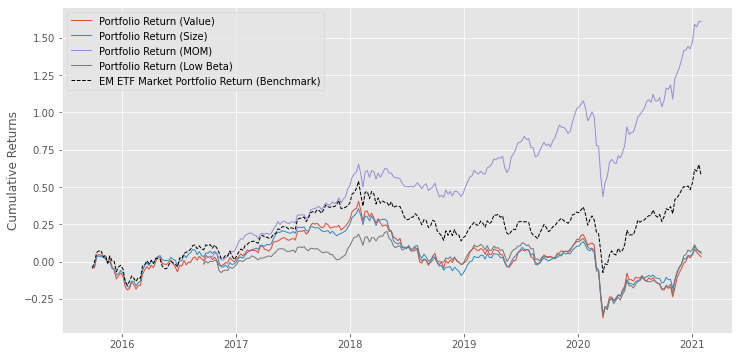

In [23]:
# Plot
plot_perf(perf=[value_ew_rets['cum_rets'], size_ew_rets['cum_rets'], mom_ew_rets['cum_rets'], low_beta_ew_rets['cum_rets']], \
          perf_bm=market_rets_w['EEM_cum_rets'], label=['Value', 'Size', 'MOM', 'Low Beta',])

In [24]:
# Performance Assessment
# Country factor portfolios
value_ew_perf = calc_performance(value_ew_rets['EW log returns'])
size_ew_perf = calc_performance(size_ew_rets['EW log returns'])
mom_ew_perf = calc_performance(mom_ew_rets['EW log returns'])
low_beta_ew_perf = calc_performance(low_beta_ew_rets['EW log returns'])

# Market
market_perf = calc_performance(market_rets_w['EEM ETF'])

In [25]:
value_ew_perf

[0.58, 24.54]

In [26]:
size_ew_perf

[1.17, 21.19]

In [27]:
mom_ew_perf

[21.82, 17.05]

In [28]:
low_beta_ew_perf

[1.23, 21.95]

## Tests / Experiments

In [29]:
def construct_factor(df_factor_measure, df_return_all, ascending):
    
    df_rank = df_factor_measure.rank(axis=1, ascending=ascending, pct=True)

    df_pos = df_rank.applymap(lambda x:1 if x <= 1/3 else 0)
    df_neg = df_rank.applymap(lambda x:-1 if x > 2/3 else 0)
    
    df_return = df_return_all.loc[df_factor_measure.index, df_factor_measure.columns]

    df_pos_ret_country = df_pos.multiply(df_return).div(df_pos.sum(axis=1), axis=0)
    df_pos_ret = df_pos_ret_country.sum(axis=1)
    
    df_neg_ret_country = df_neg.multiply(df_return).div(-df_neg.sum(axis=1), axis=0)
    df_neg_ret = df_neg_ret_country.sum(axis=1)
    
    df_factor_ret = df_pos_ret + df_neg_ret
    df_port = df_pos + df_neg
    
    return df_factor_ret, df_port

In [30]:
#size_factor_ret, size_factor_port = construct_factor(mv_monthly_selected, bnd_index_excess_ret, ascending=False)

In [31]:
mom_factor_ret, mom_factor_port = construct_factor(rolling_ret_mom, equity_rets_w, ascending=False)
low_beta_factor_ret, low_beta_factor_port = construct_factor(betas_df, equity_rets_w, ascending=True)
#value_factor_ret, value_factor_port = construct_factor(country_pe, equity_rets_w, ascending=False)

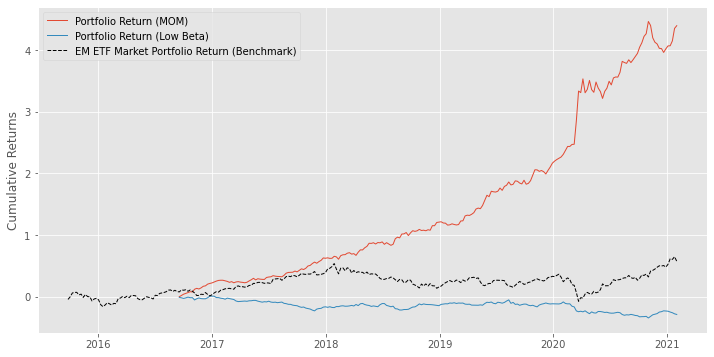

In [32]:
# Plot
#np.exp(out_df['EW log returns'].cumsum())-1
plot_perf(perf=[np.exp(mom_factor_ret.cumsum())-1, np.exp(low_beta_factor_ret.cumsum())-1], \
          perf_bm=market_rets_w['EEM_cum_rets'], label=['MOM', 'Low Beta',])